# Esercitazione lab7
#### Machine Learning

Confronto su un dataset (es. WBC) di modelli basati su alberi:

* Alberi di decisione
* Voting Classifier di alberi semplici (es. profondità max 2)
* Foresta Casuale di alberi semplici
* Bagging di alberi semplici
* Boosting di alberi semplici
* Stacking Classifier

Bisogna ottenere i parametri migliori utilizzando:
+ CV esterna per variare i test set (Grid / Randomized)
+ CV interna per il fine-tuning degli iperparametri

Visualizzare su schermo gli alberi di decisione e utilizzare l'Isolation Forest per eliminare gli outliers.

Replicare il confronto su dataset / problema di *regressione*.

## <font color='yellow'> Problema di Classificazione: </font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

### Preprocessing

#### Caricamento del Dataset `breast_cancer`

In [9]:
from sklearn import datasets

import inspect
print(inspect.signature(datasets.load_breast_cancer))

(*, return_X_y=False, as_frame=False)


In [39]:
from sklearn import datasets

# Dataset loading
X,y = datasets.load_breast_cancer(return_X_y= True)

In [28]:
print(f"Dataset examples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Dataset examples: 569
Features: 30


In [29]:
unique, counts = np.unique(y, return_counts = True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 212, 1: 357}


#### Nested Cross Validation [classificazione]

In [30]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

def nested_cv(model, param_grid, X, y, outer_splits=5,
              inner_splits=5, scoring=['accuracy'], random_state=42, verbose=True):

    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    score_results = {metric: [] for metric in scoring}

    best_param_overall = None
    best_score = -np.inf 

    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        if verbose:
            print(f"\nPerforming Outer Fold {outer_fold}/{outer_splits}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        if verbose:
            print("Performing GridSearchCV...")

        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                   n_jobs=-1, scoring=scoring[0])
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        if verbose:
            print(f" Best Params: {best_params}")

        y_pred = best_model.predict(X_test)

        if 'accuracy' in scoring:
            acc = accuracy_score(y_test, y_pred)
            score_results['accuracy'].append(acc)

            if acc > best_score:
                best_score = acc
                best_param_overall = best_params

            if verbose:
                print(f" Accuracy: {acc:.4f}")

    result = {}
    for metric, scores in score_results.items():
        result[f"Nested CV {metric.upper()}"] = f"{np.mean(scores):.4f} ± {np.std(scores):.4f}"

    result["Best Parameters with highest accuracy"] = best_param_overall

    return result

### Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
dtc_model = DecisionTreeClassifier()
dtc_params = {
     "criterion" : ["gini", "log_loss", "entropy"],
    "max_depth" : [10, 20, 30]
}

In [36]:
start_time = time.time()

dtc_results = nested_cv(dtc_model, dtc_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"DecisionTree Classifier results: \n{dtc_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'criterion': 'log_loss', 'max_depth': 20}
 Accuracy: 0.9474

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'criterion': 'log_loss', 'max_depth': 30}
 Accuracy: 0.9561

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'criterion': 'entropy', 'max_depth': 30}
 Accuracy: 0.9298

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'criterion': 'entropy', 'max_depth': 10}
 Accuracy: 0.9474

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'criterion': 'gini', 'max_depth': 10}
 Accuracy: 0.9469
DecisionTree Classifier results: 
{'Nested CV ACCURACY': '0.9455 ± 0.0086', 'Best Parameters with highest accuracy': {'criterion': 'log_loss', 'max_depth': 30}}
Execution time: 0.4457671642303467 s


#### Visualizzazione dell'Albero

Si vuole visualizzare un albero di profondità pari a $3$, utilizzando il metodo `plot_tree`: è possibile visionare sia con un grafico sia in forma testuale.

In [40]:
from sklearn.tree import plot_tree

In [41]:
b_cancer = datasets.load_breast_cancer()

In [42]:
dtc_model = DecisionTreeClassifier(max_depth = 3)  
dtc_model.fit(X, y)
feature_names = b_cancer.feature_names

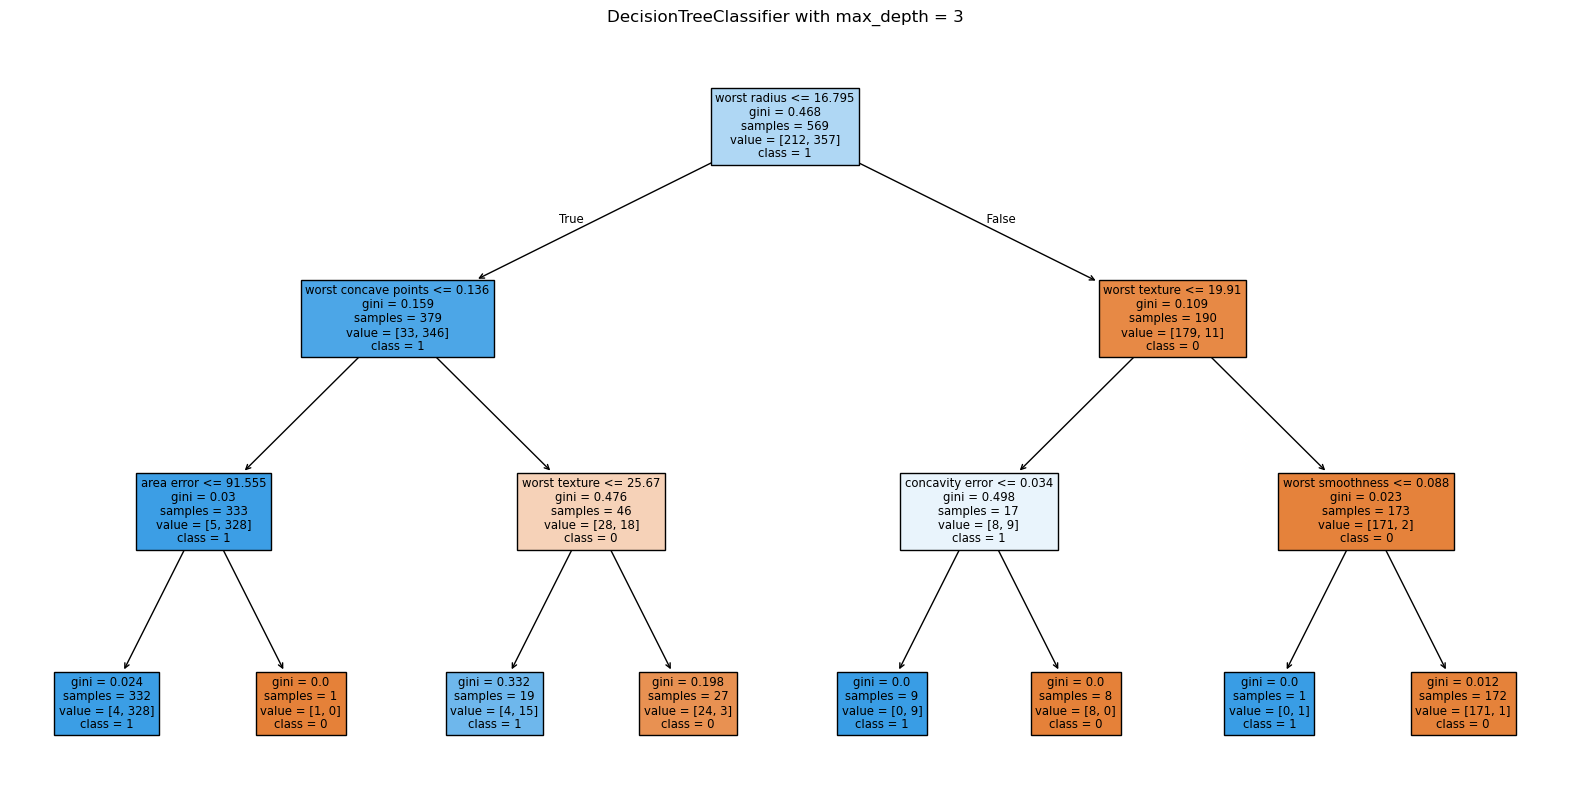

In [43]:
plt.figure(figsize = (20, 10))  
plot_tree(dtc_model, filled = True, feature_names = feature_names, class_names = [str(i) for i in dtc_model.classes_])
plt.title("DecisionTreeClassifier with max_depth = 3")
plt.show()

#### Rule exporting con `export_text`

In [44]:
from sklearn.tree import export_text

In [45]:
r = export_text(dtc_model, feature_names = feature_names)
print(r)

|--- worst radius <= 16.80
|   |--- worst concave points <= 0.14
|   |   |--- area error <= 91.56
|   |   |   |--- class: 1
|   |   |--- area error >  91.56
|   |   |   |--- class: 0
|   |--- worst concave points >  0.14
|   |   |--- worst texture <= 25.67
|   |   |   |--- class: 1
|   |   |--- worst texture >  25.67
|   |   |   |--- class: 0
|--- worst radius >  16.80
|   |--- worst texture <= 19.91
|   |   |--- concavity error <= 0.03
|   |   |   |--- class: 1
|   |   |--- concavity error >  0.03
|   |   |   |--- class: 0
|   |--- worst texture >  19.91
|   |   |--- worst smoothness <= 0.09
|   |   |   |--- class: 1
|   |   |--- worst smoothness >  0.09
|   |   |   |--- class: 0



### Metodi Ensemble

#### Bagging Classifier

In [134]:
from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [135]:
bgc_model = BaggingClassifier()

bgc_params = {
    "n_estimators": [10, 20, 50],
    "estimator": [DecisionTreeClassifier(max_depth=3), KNeighborsClassifier(n_neighbors=3)],  
    "bootstrap": [True, False]
}

In [136]:
start_time = time.time()

bgc_results = nested_cv(bgc_model, bgc_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"Bagging Classifier results: \n{bgc_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'bootstrap': True, 'estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 20}
 Accuracy: 0.9561

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'bootstrap': True, 'estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 50}
 Accuracy: 0.9649

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'bootstrap': True, 'estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 20}
 Accuracy: 0.9386

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'bootstrap': True, 'estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 20}
 Accuracy: 0.9561

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'bootstrap': True, 'estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 50}
 Accuracy: 0.9381
Bagging Classifier results: 
{'Nested CV ACCURACY': '0.9508 ± 0.0107', 'Best Parameters with highest accuracy': {'bootst

#### AdaBoost Classifier

In [54]:
from sklearn.ensemble import AdaBoostClassifier

In [57]:
ada_model = AdaBoostClassifier()#algorithm = "SAMME")
ada_params = {
    "n_estimators" : [50, 100, 150],
     "learning_rate" : [0.1, 0.01, 0.001]
}

In [59]:
start_time = time.time()

ada_results = nested_cv(ada_model, ada_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"Adaboost Classifier results: \n{ada_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
 Accuracy: 0.9561

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
 Accuracy: 0.9561

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'n_estimators': 150}
 Accuracy: 0.9561

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
 Accuracy: 0.9825

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'n_estimators': 150}
 Accuracy: 0.9558
Adaboost Classifier results: 
{'Nested CV ACCURACY': '0.9613 ± 0.0106', 'Best Parameters with highest accuracy': {'learning_rate': 0.1, 'n_estimators': 100}}
Execution time: 26.56769633293152 s


#### Gradient Boosting Classifier

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
gbc_model = GradientBoostingClassifier()
gbc_params = {
    "n_estimators" : [50, 100, 150],
    "loss" : ["exponential", "log_loss"],
    "learning_rate" : [0.1, 0.01, 0.001]
}

In [62]:
start_time = time.time()

gbc_results = nested_cv(gbc_model, gbc_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"Gradient Boosting Classifier results: \n{gbc_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 150}
 Accuracy: 0.9561

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 100}
 Accuracy: 0.9561

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
 Accuracy: 0.9298

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
 Accuracy: 0.9825

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 150}
 Accuracy: 0.9469
Gradient Boosting Classifier results: 
{'Nested CV ACCURACY': '0.9543 ± 0.0170', 'Best Parameters with highest accuracy': {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}}
Execution time: 50.445704221725464 s


#### Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
rfc_model = RandomForestClassifier()

rfc_params = {
     "criterion" : ["gini", "log_loss", "entropy"],
    "max_depth" : [10, 20, 30],
    "max_features" : ["log2", "sqrt"]
}

In [65]:
start_time = time.time()

rfc_results = nested_cv(rfc_model, rfc_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"Random Forest Classifier results: \n{rfc_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2'}
 Accuracy: 0.9649

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2'}
 Accuracy: 0.9825

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'criterion': 'log_loss', 'max_depth': 30, 'max_features': 'sqrt'}
 Accuracy: 0.9474

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}
 Accuracy: 0.9649

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2'}
 Accuracy: 0.9558
Random Forest Classifier results: 
{'Nested CV ACCURACY': '0.9631 ± 0.0117', 'Best Parameters with highest accuracy': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2'}}
Execution time: 24.9152889251709 s


#### Extra Trees Classifier

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

In [69]:
etc_model = ExtraTreesClassifier()

etc_params = {
    "n_estimators": [10, 50, 100],
    "criterion": ["gini", "entropy", "log_loss"],  
    "max_depth": [5, 10, 20],
    #"min_samples_split": [2, 5, 10],
    #"min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

In [70]:
start_time = time.time()

etc_results = nested_cv(etc_model, etc_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ['accuracy'])

end_time = time.time()

print(f"Extra Trees Classifier results:")
display(etc_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
 Accuracy: 0.9737

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 10}
 Accuracy: 0.9649

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
 Accuracy: 0.9298

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
 Accuracy: 0.9737

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}
 Accuracy: 0.9469
Extra Trees Classifier results:


{'Nested CV ACCURACY': '0.9578 ± 0.0171',
 'Best Parameters with highest accuracy': {'criterion': 'gini',
  'max_depth': 10,
  'max_features': 'sqrt',
  'n_estimators': 50}}

Execution time: 28.405933141708374 s


#### Voting Classifier

In [71]:
from sklearn.ensemble import VotingClassifier

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [73]:
estimators = [
    ("rfc", RandomForestClassifier(random_state = 42)),
    ("gbc", GradientBoostingClassifier(random_state = 42)),
    ("etc", ExtraTreesClassifier(random_state = 42))
]

vtc_model = VotingClassifier(estimators = estimators)

vtc_params = {
    "voting" : ["hard", "soft"]
}

In [74]:
start_time = time.time()

vtc_results = nested_cv(vtc_model, vtc_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"Voting Classifier results: \n{vtc_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'voting': 'soft'}
 Accuracy: 0.9649

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'voting': 'soft'}
 Accuracy: 0.9825

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'voting': 'hard'}
 Accuracy: 0.9649

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'voting': 'soft'}
 Accuracy: 0.9825

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'voting': 'soft'}
 Accuracy: 0.9646
Voting Classifier results: 
{'Nested CV ACCURACY': '0.9719 ± 0.0086', 'Best Parameters with highest accuracy': {'voting': 'soft'}}
Execution time: 12.115152597427368 s


#### Stacking Classifier

In [75]:
from sklearn.ensemble import StackingClassifier

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [77]:
estimators = [
    ("knc", KNeighborsClassifier()),
    ("rfc", RandomForestClassifier(random_state = 42)),
    ("gnb", GaussianNB())
]

stc_model = StackingClassifier(estimators = estimators)

stc_params = {
    "stack_method": ["predict_proba", "predict"] 
}

In [78]:
start_time = time.time()

stc_results = nested_cv(stc_model, stc_params, X, y,
                                   outer_splits = 5, inner_splits = 5,
                                   scoring = ["accuracy"])

end_time = time.time()

print(f"Stacking Classifier results: \n{stc_results}")
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'stack_method': 'predict_proba'}
 Accuracy: 0.9737

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'stack_method': 'predict_proba'}
 Accuracy: 0.9649

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'stack_method': 'predict_proba'}
 Accuracy: 0.9474

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'stack_method': 'predict'}
 Accuracy: 0.9561

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'stack_method': 'predict_proba'}
 Accuracy: 0.9469
Stacking Classifier results: 
{'Nested CV ACCURACY': '0.9578 ± 0.0103', 'Best Parameters with highest accuracy': {'stack_method': 'predict_proba'}}
Execution time: 20.046314477920532 s


## <font color='yellow'> Problema di Regressione: </font>

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

### Preprocessing

#### Caricamento del Dataset `linnerud`

Il dataset `linnerud` è un set di dati di regressione multi-output: per questo motivo, è necessario aggiungere uno "strato" di `MultiOutputRegressor` per ogni modello di regressione che si andrà ad utilizzare.

In [187]:
from sklearn.multioutput import MultiOutputRegressor

In [80]:
from sklearn import datasets

# Dataset loading
linnerud = datasets.load_linnerud()

X, y = datasets.load_linnerud(return_X_y= True)

In [81]:
print(f"Dataset examples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Dataset examples: 20
Features: 3


In [82]:
print(f"Target names: {linnerud.target_names}")
print(f"Features names: {linnerud.feature_names}")

Target names: ['Weight', 'Waist', 'Pulse']
Features names: ['Chins', 'Situps', 'Jumps']


In [83]:
print(linnerud.DESCR)

.. _linnerrud_dataset:

Linnerrud dataset
-----------------

**Data Set Characteristics:**

:Number of Instances: 20
:Number of Attributes: 3
:Missing Attribute Values: None

The Linnerud dataset is a multi-output regression dataset. It consists of three
exercise (data) and three physiological (target) variables collected from
twenty middle-aged men in a fitness club:

- *physiological* - CSV containing 20 observations on 3 physiological variables:
   Weight, Waist and Pulse.
- *exercise* - CSV containing 20 observations on 3 exercise variables:
   Chins, Situps and Jumps.

.. dropdown:: References

   * Tenenhaus, M. (1998). La regression PLS: theorie et pratique. Paris:
     Editions Technic.



## Nested CV [regressione]

In [88]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def nested_cv_regression(model, param_grid, X, y, outer_splits=5,
                         inner_splits=5, scoring=None, random_state=42, verbose=True):
    if scoring is None:
        scoring = ['r2']  # Default metric

    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    score_results = {metric: [] for metric in scoring}

    best_param_overall = None
    best_r2_score = -np.inf 

    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        if verbose:
            print(f"\nPerforming Outer Fold {outer_fold}/{outer_splits}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        if verbose:
            print("Performing GridSearchCV...")

        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                   n_jobs=-1, scoring=scoring[0])
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        if verbose:
            print(f" Best Params: {best_params}")

        y_pred = best_model.predict(X_test)

        if 'r2' in scoring:
            r2 = r2_score(y_test, y_pred)
            score_results['r2'].append(r2)
            if r2 > best_r2_score:
                best_r2_score = r2
                best_param_overall = best_params
            if verbose:
                print(f" R²: {r2:.4f}")

        if 'mae' in scoring:
            mae = mean_absolute_error(y_test, y_pred)
            score_results['mae'].append(mae)
            if verbose:
                print(f" MAE: {mae:.4f}")

        if 'rmse' in scoring:
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            score_results['rmse'].append(rmse)
            if verbose:
                print(f" RMSE: {rmse:.4f}")

    result = {}
    for metric, scores in score_results.items():
        result[f"Nested CV {metric.upper()}"] = f"{np.mean(scores):.4f} ± {np.std(scores):.4f}"

    result["Best Parameters with highest R2 score"] = best_param_overall

    return result

### Decision Tree Regressor

In [85]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

In [86]:
dtr_model = MultiOutputRegressor(DecisionTreeRegressor(random_state = 42))

dtr_params = {
    "estimator__max_depth": [1, 2, 5, 10],
    "estimator__splitter": ["best", "random"]
}

In [89]:
start_time = time.time()

dtr_results = nested_cv_regression(dtr_model, dtr_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2"])

end_time = time.time()

print(f"Decision Tree Regressor results:")
display(dtr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 1, 'estimator__splitter': 'best'}
 R²: -0.4967

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 1, 'estimator__splitter': 'random'}
 R²: -1.1030

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 1, 'estimator__splitter': 'random'}
 R²: -0.9596

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 1, 'estimator__splitter': 'random'}
 R²: -5.3509

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 1, 'estimator__splitter': 'random'}
 R²: -0.3240
Decision Tree Regressor results:


{'Nested CV R2': '-1.6468 ± 1.8741',
 'Best Parameters with highest R2 score': {'estimator__max_depth': 1,
  'estimator__splitter': 'random'}}

Execution time: 1.9362075328826904 s


### Metodi Ensemble

#### Bagging Regressor

In [90]:
from sklearn.ensemble import BaggingRegressor

In [91]:
bgr_model = MultiOutputRegressor(BaggingRegressor(random_state = 42))

bgr_params = {
    "estimator__n_estimators": [10, 50, 100],
    "estimator__max_samples": [0.5, 0.7, 1.0],
    "estimator__max_features": [0.5, 0.7, 1.0],
}

In [93]:
start_time = time.time()

bgr_results = nested_cv_regression(bgr_model, bgr_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"Bagging Regressor results:")
display(bgr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__max_features': 1.0, 'estimator__max_samples': 0.5, 'estimator__n_estimators': 50}
 R²: -0.3446
 MAE: 8.7967
 RMSE: 12.8127

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__max_features': 0.5, 'estimator__max_samples': 1.0, 'estimator__n_estimators': 10}
 R²: -1.2302
 MAE: 8.1694
 RMSE: 10.7027

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__max_features': 0.5, 'estimator__max_samples': 0.5, 'estimator__n_estimators': 100}
 R²: -0.7283
 MAE: 11.4604
 RMSE: 21.9537

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__max_features': 0.5, 'estimator__max_samples': 1.0, 'estimator__n_estimators': 50}
 R²: -2.5062
 MAE: 11.4271
 RMSE: 18.0223

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__max_features': 0.5, 'estimator__max_samples': 0.5, 'estimator__n_estimators': 10}
 R²: -0.1852
 MAE:

{'Nested CV R2': '-0.9989 ± 0.8353',
 'Nested CV RMSE': '14.9242 ± 4.3747',
 'Nested CV MAE': '9.5018 ± 1.6263',
 'Best Parameters with highest R2 score': {'estimator__max_features': 0.5,
  'estimator__max_samples': 0.5,
  'estimator__n_estimators': 10}}

Execution time: 63.868793964385986 s


#### AdaBoost Regressor

In [94]:
from sklearn.ensemble import AdaBoostRegressor

In [95]:
abr_model = MultiOutputRegressor(AdaBoostRegressor(random_state = 42))

abr_params = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__loss" : ["linear", "square", "exponential"]
}

In [96]:
start_time = time.time()

abr_results = nested_cv_regression(abr_model, abr_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"AdaBoost Regressor results:")
display(abr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.1, 'estimator__loss': 'exponential', 'estimator__n_estimators': 50}
 R²: -1.4638
 MAE: 12.0179
 RMSE: 19.5091

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.05, 'estimator__loss': 'exponential', 'estimator__n_estimators': 50}
 R²: -2.7259
 MAE: 10.0089
 RMSE: 14.5104

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__loss': 'exponential', 'estimator__n_estimators': 100}
 R²: -1.9839
 MAE: 10.4291
 RMSE: 20.0842

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__loss': 'exponential', 'estimator__n_estimators': 50}
 R²: -2.0696
 MAE: 10.6647
 RMSE: 17.2515

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__loss': 'exponential', 'estimator__n_estimator

{'Nested CV R2': '-1.8294 ± 0.6125',
 'Nested CV RMSE': '16.8933 ± 2.7252',
 'Nested CV MAE': '10.2811 ± 1.2037',
 'Best Parameters with highest R2 score': {'estimator__learning_rate': 0.01,
  'estimator__loss': 'exponential',
  'estimator__n_estimators': 200}}

Execution time: 110.73160600662231 s


#### Gradient Boosting Regressor

In [97]:
from sklearn.ensemble import GradientBoostingRegressor

In [98]:
gbr_model = MultiOutputRegressor(GradientBoostingRegressor(random_state = 42))

gbr_params = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
}

In [100]:
start_time = time.time()

gbr_results = nested_cv_regression(gbr_model, gbr_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"Gradient Boosting Regressor results:")
display(gbr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 50}
 R²: -0.3553
 MAE: 9.6682
 RMSE: 13.4529

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 50}
 R²: -1.3827
 MAE: 7.1808
 RMSE: 10.6334

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 50}
 R²: -0.1484
 MAE: 9.2757
 RMSE: 20.2288

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 50}
 R²: -2.2946
 MAE: 11.7658
 RMSE: 17.1889

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 50}
 R²: -0.4659
 MAE: 8.1122
 RMSE: 13.3660
Gradient Boosting Regressor results:


{'Nested CV R2': '-0.9294 ± 0.8030',
 'Nested CV RMSE': '14.9740 ± 3.3544',
 'Nested CV MAE': '9.2006 ± 1.5536',
 'Best Parameters with highest R2 score': {'estimator__learning_rate': 0.01,
  'estimator__n_estimators': 50}}

Execution time: 13.423408508300781 s


#### Random Forest Regressor

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [103]:
rfr_model = MultiOutputRegressor(RandomForestRegressor(random_state = 42))

rfr_params = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 4, 6, None],
    "estimator__min_samples_split": [2, 5, 10],
     "estimator__min_samples_leaf": [1, 2, 4],
}

In [104]:
start_time = time.time()

rfr_results = nested_cv_regression(rfr_model, rfr_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"Random Forest Regressor results:")
display(rfr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 2, 'estimator__n_estimators': 200}
 R²: -0.5364
 MAE: 9.7628
 RMSE: 14.5584

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 2, 'estimator__n_estimators': 50}
 R²: -1.4003
 MAE: 7.9337
 RMSE: 11.2783

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 2, 'estimator__n_estimators': 200}
 R²: -0.5495
 MAE: 9.6358
 RMSE: 20.6669

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 6, 'estimator__n_estimators': 100}
 R²: -2.5777
 MAE: 11.8593
 RMSE: 18.0127

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__max_depth': 6, 'estimator__n_estimators': 200}
 R²: -0.8969
 MAE: 7.6680
 RMSE: 13.0837
Random Forest Regressor results:


{'Nested CV R2': '-1.1922 ± 0.7607',
 'Nested CV RMSE': '15.5200 ± 3.3928',
 'Nested CV MAE': '9.3719 ± 1.5087',
 'Best Parameters with highest R2 score': {'estimator__max_depth': 2,
  'estimator__n_estimators': 200}}

Execution time: 37.62246298789978 s


#### Extra Trees Regressor

In [105]:
from sklearn.ensemble import ExtraTreesRegressor

In [110]:
etr_model = MultiOutputRegressor(ExtraTreesRegressor(random_state = 42))

etr_params = {
    "estimator__n_estimators": [10, 50, 100],
    #"estimator__max_depth": [None, 10, 20],
    #"estimator__min_samples_split": [2, 5, 10],
    #"estimator__min_samples_leaf": [1, 2, 4],
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__criterion": ["squared_error", "absolute_error"]  
}

In [111]:
start_time = time.time()

etr_results = nested_cv_regression(etr_model, etr_params, X, y, 
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"Extra Trees Regressor results:")
display(etr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__criterion': 'absolute_error', 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 50}
 R²: -0.7130
 MAE: 9.8583
 RMSE: 13.7409

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__criterion': 'absolute_error', 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 50}
 R²: -2.1372
 MAE: 9.2500
 RMSE: 13.0843

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__criterion': 'absolute_error', 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 50}
 R²: -1.1624
 MAE: 11.6975
 RMSE: 21.9700

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__criterion': 'absolute_error', 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 10}
 R²: -2.4560
 MAE: 10.2583
 RMSE: 16.9556

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__criterion': 'squared_error', 'estimator__max_

{'Nested CV R2': '-1.3760 ± 0.7952',
 'Nested CV RMSE': '15.6087 ± 3.5535',
 'Nested CV MAE': '9.7178 ± 1.3608',
 'Best Parameters with highest R2 score': {'estimator__criterion': 'squared_error',
  'estimator__max_features': 'sqrt',
  'estimator__n_estimators': 10}}

Execution time: 17.2144832611084 s


#### Voting Regressor

In [112]:
from sklearn.ensemble import VotingRegressor

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [114]:
estimators = [
    ("rfr", RandomForestRegressor(random_state = 42)),
    ("gbr", GradientBoostingRegressor(random_state = 42)),
    ("etr", ExtraTreesRegressor(random_state = 42))
]

vtr_model = MultiOutputRegressor(VotingRegressor(estimators = estimators))

vtr_params = {
    "estimator__weights": [[0.5, 1, 2], [1, 1, 1], [0.2, 0.5, 0.8]]  
}

In [115]:
start_time = time.time()

vtr_results = nested_cv_regression(vtr_model, vtr_params, X, y,
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"Voting Regressor results:")
display(vtr_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__weights': [0.5, 1, 2]}
 R²: -1.0021
 MAE: 9.6990
 RMSE: 15.3507

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__weights': [0.5, 1, 2]}
 R²: -2.7322
 MAE: 9.8876
 RMSE: 14.2128

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__weights': [1, 1, 1]}
 R²: -1.0909
 MAE: 10.5034
 RMSE: 22.1940

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__weights': [1, 1, 1]}
 R²: -2.2254
 MAE: 11.5835
 RMSE: 17.7468

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'estimator__weights': [1, 1, 1]}
 R²: -0.8028
 MAE: 7.3689
 RMSE: 12.4710
Voting Regressor results:


{'Nested CV R2': '-1.5707 ± 0.7643',
 'Nested CV RMSE': '16.3951 ± 3.3677',
 'Nested CV MAE': '9.8085 ± 1.3859',
 'Best Parameters with highest R2 score': {'estimator__weights': [1, 1, 1]}}

Execution time: 21.360268592834473 s


#### Stacking Regressor

In [116]:
from sklearn.ensemble import StackingRegressor

In [117]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [118]:
estimators = [
    ("lgr", RidgeCV()),
    ("svr", SVR(kernel = "linear"))
]

base_str_model = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(random_state = 42),
    verbose = True
)

str_model = MultiOutputRegressor(base_str_model)

str_params = {
    "estimator__final_estimator__n_estimators": [50, 100],
    "estimator__final_estimator__max_depth": [3, 5, None],
    "estimator__svr__C": [0.1, 1.0, 10.0],
    "estimator__svr__epsilon": [0.1, 0.2]
}

In [119]:
start_time = time.time()

str_results = nested_cv_regression(str_model, str_params, X, y,
                                  outer_splits = 5, inner_splits = 5,
                                  scoring = ["r2", "rmse", "mae"])

end_time = time.time()

print(f"Stacking Regressor results:")
display(str_results)
print(f"Execution time: {end_time - start_time} s")


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'estimator__final_estimator__max_depth': 3, 'estimator__final_estimator__n_estimators': 100, 'estimator__svr__C': 1.0, 'estimator__svr__epsilon': 0.2}
 R²: -0.4298
 MAE: 8.6833
 RMSE: 14.5603

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'estimator__final_estimator__max_depth': 3, 'estimator__final_estimator__n_estimators': 50, 'estimator__svr__C': 1.0, 'estimator__svr__epsilon': 0.2}
 R²: -1.8197
 MAE: 7.1263
 RMSE: 12.3980

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'estimator__final_estimator__max_depth': 3, 'estimator__final_estimator__n_estimators': 100, 'estimator__svr__C': 10.0, 'estimator__svr__epsilon': 0.1}
 R²: -6.9594
 MAE: 15.8941
 RMSE: 26.9965

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'estimator__final_estimator__max_depth': 3, 'estimator__final_estimator__n_estimators': 100, 'estimator__svr__C': 0.1, 'estimator__svr__epsilon': 0

{'Nested CV R2': '-3.9132 ± 3.9679',
 'Nested CV RMSE': '18.0197 ± 5.2261',
 'Nested CV MAE': '10.7496 ± 3.2579',
 'Best Parameters with highest R2 score': {'estimator__final_estimator__max_depth': 3,
  'estimator__final_estimator__n_estimators': 100,
  'estimator__svr__C': 0.1,
  'estimator__svr__epsilon': 0.1}}

Execution time: 165.76055693626404 s


## <font color = "lightgreen">Appendice</font>: Isolation Forest

Si utilizza la classe di Scikit-Learn `IsolationForest` per poter individuare gli outlier ed eliminarli, in modo da ottenere dei risultati migliori.

Per esperimento, si considera un classificatore di tipo **Random Forest**.

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

### Preprocessing

#### Caricamento del Dataset `breast_cancer`

In [122]:
from sklearn import datasets

# Dataset loading
b_cancer = datasets.load_breast_cancer()
X, y =  datasets.load_breast_cancer(return_X_y = True)

In [123]:
print(f"Dataset examples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Dataset examples: 569
Features: 30


In [124]:
unique, counts = np.unique(y, return_counts = True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 212, 1: 357}


### Isolation Forest Classifier

In [125]:
from sklearn.ensemble import IsolationForest # Outlier detection
from sklearn.ensemble import RandomForestClassifier # Model

In [131]:
# Fit Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)  # adjust contamination rate as needed
outlier_pred = iso.fit_predict(X)

# Filter out the outliers
# -1 = outlier, 1 = inlier
X_clean = X[outlier_pred == 1]
y_clean = y[outlier_pred == 1]  

In [132]:
# Define the model
rfc_model = RandomForestClassifier(random_state=42, oob_score=True)

# Apply K-Fold CV 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc_model, X_clean, y_clean, cv=5, scoring='accuracy')

In [133]:
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Standard Deviation:", np.std(scores))

Cross-Validation Scores: [0.92592593 0.92592593 0.98148148 0.97222222 0.97222222]
Mean Accuracy: 0.9555555555555555
Standard Deviation: 0.024427603626431333
